In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = '/content/drive/MyDrive/Copy of ssl_dataset.zip'  # Change this to your actual file path
extract_to = '/content/ssl_dataset'
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to {extract_to}")

Extracted to /content/ssl_dataset


In [3]:
import os
import shutil

# Correct base path
base_dir = '/content/ssl_dataset/ssl_dataset'
train_folders = ['train.X1', 'train.X2', 'train.X3', 'train.X4']

# Destination folder
target_dir = '/content/unzipped_dataset/combined_train'

# Create target folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Loop through each train.X* folder
for train_folder in train_folders:
    full_train_path = os.path.join(base_dir, train_folder)

    # Check if the folder exists
    if not os.path.exists(full_train_path):
        print(f"❌ Folder not found: {full_train_path}")
        continue

    # Loop through each class folder inside train.X*
    for class_folder in os.listdir(full_train_path):
        source_path = os.path.join(full_train_path, class_folder)
        target_path = os.path.join(target_dir, f"{train_folder}_{class_folder}")  # Avoid name conflicts

        shutil.copytree(source_path, target_path)

print("✅ All class folders copied to:", target_dir)


✅ All class folders copied to: /content/unzipped_dataset/combined_train


In [1]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms, datasets

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# TensorBoard
%load_ext tensorboard

# Path to the dataset (you can modify this if needed)
DATASET_PATH = "/content/unzipped_dataset/combined_train"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/simclr_imagenet100"

# Set number of workers (recommended: number of CPU cores)
NUM_WORKERS = os.cpu_count()

# Set random seed
pl.seed_everything(42)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)


<ipython-input-1-be88aa3017cf>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')  # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

In [6]:
shutil.rmtree('/content/ssl_dataset')

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [3]:

class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [4]:
from torchvision import transforms

contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5,
                               contrast=0.5,
                               saturation=0.5,
                               hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # For RGB channels
                         std=[0.229, 0.224, 0.225])
])


In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load dataset
train_data_contrast = ImageFolder(
    root="/content/unzipped_dataset/combined_train",
    transform=ContrastiveTransformations(contrast_transforms, n_views=2)
)

# Create DataLoader
train_loader = DataLoader(
    train_data_contrast,
    batch_size=256,  # or your preferred batch size
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [6]:
import shutil
import os

root_dir = "/content/unzipped_dataset/combined_train"

for dirpath, dirnames, filenames in os.walk(root_dir):
    if ".ipynb_checkpoints" in dirnames:
        checkpoint_path = os.path.join(dirpath, ".ipynb_checkpoints")
        print(f"Removing {checkpoint_path}")
        shutil.rmtree(checkpoint_path)

INFO:lightning_fabric.utilities.seed:Seed set to 42


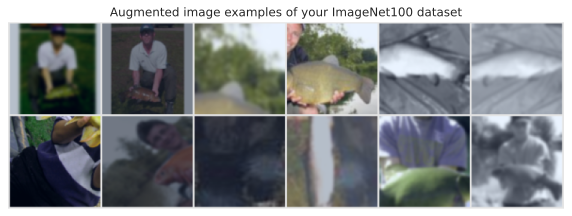

In [7]:
pl.seed_everything(42)
NUM_IMAGES = 6

# Get augmented views of images from your dataset
# Each item from train_data_contrast returns a list of augmented views [view1, view2]
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_data_contrast[idx][0]], dim=0)

img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C) for plt

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of your ImageNet100 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


In [8]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [9]:
from pytorch_lightning.loggers import TensorBoardLogger

def train_simclr(batch_size, max_epochs=500, **kwargs):
    logger = TensorBoardLogger(save_dir=os.path.join(CHECKPOINT_PATH, 'tensorboards'), name='SimCLR')

    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        logger=logger,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                   LearningRateMonitor('epoch')]
    )

    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42)
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model


In [10]:
simclr_model = train_simclr(batch_size=128,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model at ../saved_models/simclr_imagenet100/SimCLR.ckpt, loading...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/simclr_imagenet100/SimCLR.ckpt`


In [ ]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            imgs, lbls = batch

            # Handle if imgs is a list/tuple of augmented views (take first view)
            if isinstance(imgs, (list, tuple)):
                imgs = imgs[0]

            imgs = imgs.to(device)

            # If imgs is a single image (3D), add batch dimension
            if imgs.dim() == 3:
                imgs = imgs.unsqueeze(0)

            feats = model.convnet(imgs)  # Extract features from backbone

            features.append(feats.cpu())
            labels.append(lbls)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

def train_logistic_regression(simclr_model, train_dataset, val_dataset, batch_size, feature_dim, num_classes, lr=3e-4, weight_decay=1e-4, max_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    simclr_model.to(device)
    simclr_model.eval()  # freeze simclr

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    # Extract features
    train_features, train_labels = extract_features(simclr_model, train_loader, device)
    val_features, val_labels = extract_features(simclr_model, val_loader, device)

    # Create datasets for logistic regression training
    train_feat_dataset = data.TensorDataset(train_features, train_labels)
    val_feat_dataset = data.TensorDataset(val_features, val_labels)

    train_feat_loader = data.DataLoader(train_feat_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_feat_loader = data.DataLoader(val_feat_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    # Initialize logistic regression model
    log_reg = LogisticRegression(feature_dim=feature_dim, num_classes=num_classes, lr=lr, weight_decay=weight_decay, max_epochs=max_epochs)

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[ModelCheckpoint(monitor='val_acc', mode='max'), LearningRateMonitor('epoch')]
    )

    trainer.fit(log_reg, train_feat_loader, val_feat_loader)
    return log_reg
from torchvision.datasets import ImageFolder

normal_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageFolder(root="/content/unzipped_dataset/combined_train", transform=normal_transform)
val_dataset = ImageFolder(root="/content/unzipped_dataset/val.X", transform=normal_transform)

log_reg_model = train_logistic_regression(simclr_model=simclr_model,
                                          train_dataset=train_dataset,
                                          val_dataset=val_dataset,
                                          batch_size=256,
                                          feature_dim=128,
                                          num_classes=100,
                                          lr=3e-4,
                                          weight_decay=1e-4,
                                          max_epochs=100)


In [12]:
train_feats, train_labels = extract_features(simclr_model, train_loader, device)
print(f"Train features shape: {train_feats.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train features shape: torch.Size([130000, 128])
Train labels shape: torch.Size([130000])


In [15]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
val_feats, val_labels = extract_features(simclr_model, val_loader, device)
print(f"Val features shape: {val_feats.shape}")
print(f"Val labels shape: {val_labels.shape}")

Val features shape: torch.Size([79, 128])
Val labels shape: torch.Size([5000])


In [ ]:
# Standard ImageNet normalization
img_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set up paths for your dataset
train_data_path = "/content/unzipped_dataset/combined_train"  # You can concatenate X1–X4 later
val_data_path = "/content/unzipped_dataset/val.X"

# Load labeled datasets
train_img_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms)
val_img_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of validation examples:", len(val_img_data))
print("Number of classes:", len(train_img_data.classes))


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from tqdm import tqdm
import torch.nn.functional as F

@torch.no_grad()
def prepare_data_features(model, dataset):
    """
    Extracts feature representations from a pretrained SimCLR encoder (f(.)),
    discarding the projection head (g(.)).

    Args:
        model: Trained SimCLR model.
        dataset: Torch Dataset (e.g., ImageFolder with transforms applied).

    Returns:
        TensorDataset of (features, labels) sorted by labels.
    """
    # Clone and prepare model encoder
    encoder = deepcopy(model.convnet)
    encoder.fc = nn.Identity()  # Remove projection head
    encoder.eval().to(device)

    # Extract features
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    all_feats, all_labels = [], []

    for imgs, labels in tqdm(data_loader, desc="Extracting features"):
        imgs = imgs.to(device)
        feats = encoder(imgs)
        all_feats.append(feats.cpu())
        all_labels.append(labels)

    # Stack and sort by label
    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    sorted_labels, sort_idx = all_labels.sort()
    sorted_feats = all_feats[sort_idx]

    return TensorDataset(sorted_feats, sorted_labels)


In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)


In [ ]:
log_reg_model, results = train_logreg(
    batch_size=256,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    model_suffix="simclr-imagenet100",
    feature_dim=simclr_model.hparams.hidden_dim,  # or 128 if hardcoded
    num_classes=100,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label, num_classes=100):
    """
    Reduces a dataset to a smaller one by selecting `num_imgs_per_label` images per label.

    Parameters:
    - original_dataset (TensorDataset): The full dataset with features and labels.
    - num_imgs_per_label (int): Number of samples to retain per class.
    - num_classes (int): Total number of classes (default is 100 for ImageNet-100).

    Returns:
    - TensorDataset: A smaller dataset with `num_imgs_per_label * num_classes` samples.
    """
    feats, labels = original_dataset.tensors

    smaller_feats, smaller_labels = [], []

    for class_idx in range(num_classes):
        class_mask = labels == class_idx
        class_feats = feats[class_mask]
        class_labels = labels[class_mask]

        if len(class_feats) < num_imgs_per_label:
            raise ValueError(f"Not enough samples for class {class_idx}: only {len(class_feats)} found.")

        smaller_feats.append(class_feats[:num_imgs_per_label])
        smaller_labels.append(class_labels[:num_imgs_per_label])

    # Concatenate all selected features and labels
    new_feats = torch.cat(smaller_feats, dim=0)
    new_labels = torch.cat(smaller_labels, dim=0)

    return data.TensorDataset(new_feats, new_labels)


In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label, num_classes=100)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=100,  # Fixed here
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results


In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*",
         markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("ImageNet-100 classification over dataset size", fontsize=14)  # <- updated title
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')


In [ ]:
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.optim as optim
import torchvision

class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Use pretrained ResNet18 backbone optionally
        self.model = torchvision.models.resnet18(pretrained=False)
        # Replace the final fc layer to match number of classes
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.7),
                                                                  int(self.hparams.max_epochs*0.9)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Log loss and accuracy per step/epoch
        self.log(f'{mode}_loss', loss, prog_bar=True, on_step=(mode=='train'), on_epoch=True)
        self.log(f'{mode}_acc', acc, prog_bar=True, on_step=(mode=='train'), on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop and resize to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Standard ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])
train_img_aug_data = torchvision.datasets.ImageFolder(root=YOUR_IMAGENET100_TRAIN_PATH,
                                                     transform=train_transforms)

In [ ]:
import os
import torch
from torch.utils import data
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# Assume train_img_aug_data and test_img_data are prepared with ImageFolder + transforms

def train_resnet(batch_size, max_epochs=100, **kwargs):
    os.makedirs(CHECKPOINT_PATH, exist_ok=True)

    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None

    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                 drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, val_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result


In [ ]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)

print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['val']:4.2f}%")


In [ ]:
def transforms():
    return Compose([RandomResizedCrop(size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2),
                    RandomHorizontalFlip(p=0.5),
                    ToTensor()])

def load_img(img_loc, transforms):
    img = Image.open(img_loc)
    return transforms(img)

load_img = partial(load_img, transforms=transforms())

In [ ]:
from timm.layers.patch_embed import PatchEmbed
from timm.layers.pos_embed import
pe = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=768, norm_layer=nn.LayerNorm)
embed = pe(img.unsqueeze(0))
embed.shape

In [ ]:
decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=768,
                out_channels=patch_size ** 2 * 3, kernel_size=1),
            nn.PixelShuffle(patch_size),
        )


In [ ]:
x = imgp[mask.bool(), ...]
x_rec = out[mask.bool(), ...]
x_rec.shape, x.shape
torch.nn.functional.l1_loss(x, x_rec, reduction='none').mean()
